In [889]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
if (code_show){
$('div.input').hide();
} else {
$('div.input').show();
}
code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="This documment is written in a Jupyter notebook and the code used to produce these analyses has been hidden for ease of reading.  
To make the code visiable click here"></form>''')

In [ ]:
## Import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns; sns.set()
from sklearn.preprocessing import StandardScaler

# Propensity Modelling

## Modelling to identify customers who might take up or buy a specific product
### Contact the right customers with the right offer to the right channel at the right time


Vodacom launced the digital contents initiative in Septemter 2017. The service amongst others include the ability to buy applications from sevices like Google Play and having the option to pay with airtime or get billed to your Vodacom contract.

The benefit to Vodacom is two-fold. There is a shared revenue agreement with the different service providers and as a result of purchasing and downlaoding apps data usage also increases.

Since its inception the digitial contents intiative has not used any advanced machine learning in or intelligent campaigns in order to target and expand this product offering and marketing this to new customers.

The purpose of this study is to determine if we are able to use machine learning and 3 months worth of historical data to train a model that will be able to predict and identify new customers to which Vodacom can expand and market the digital contents offering.

The scope of this project is focused on the Google Play service since that is where the most potential revenue lies. This can always be expanded to the other 8 digital channels like Netflix for example.


The Data has attributes of 100,000 customers who were randomly drawn from the subset of customers who are data users.It contains three months data, that is May,June and July.
The labels were tagged based on whether the customer did or did not purchase a digital content in the Month of August.

We have about 17% who bought and 83% who did not buy



In [882]:
#df= pd.read_csv("digital_content_services.csv")

df = pd.read_csv("/Users/dgitahi/documents/github/Propensity-Model/digital_content_services.csv")

### Below is snapshot of the data

In [883]:
df.head()

,EVENT_MONTH,MSISDN,MANUFACTURER,MODEL,OPERATING_SYSTEM,SERVICE_PROVIDER_ID,SERVICE_NAME,CONTENT_DESCRIPTION,REQUEST_TYPE,TRANSACTION_STATUS,...,CONNECTED_DAYS,CONNECTED_YEARS,PAYMENT_METHOD,CNT_DIGITAL_TRANSACTIONS,TOTAL_VOL_MB,CNT_ACTV_DATA_DAYS,AMOUNT_EXCL_VAT,CNT_ACTV_VOICE_DAYS,EVENT_DURATION_SEC,EVENT_DUR_MIN
0,May-18,C6034E1834450E,Samsung,Galaxy J1 ACE SM-J111F,ANDROID,GooglePlay,Google Play Application,Google Play Application,DEBIT,ACCEPTED,...,444,1.22,P,1.0,718.61938,31,0.00,30.0,25168.0,419.47
1,Aug-18,C6034D0909591F,Samsung,SM-N9005 Galaxy Note 3 LTE,ANDROID,DCB SGN,GameMine,GameMine,DEBIT,UNKNOWN,...,159,0.44,P,1.0,2405.75596,8,10.44,14.0,7554.0,125.90
2,Aug-18,C6034D0A252019,Vodafone,Vodafone Smart ultra 7,ANDROID,GooglePlay,Google Play Application,Google Play Application,DEBIT,ACCEPTED,...,1231,3.37,P,1.0,1672.35587,17,0.00,28.0,9722.0,162.03
3,May-18,C6034E1C281C03,Vodafone,Vodafone Smart mini 7,ANDROID,GooglePlay,Google Play Application,Google Play Application,DEBIT,ACCEPTED,...,630,1.73,P,6.0,1135.98838,31,0.00,31.0,6444.0,107.40
4,Aug-18,C6034E3E305B0D,Samsung Korea,GALAXY GRAND PRIME,ANDROID,GooglePlay,Google Play Application,Google Play Application,DEBIT,ACCEPTED,...,388,1.06,P,1.0,0.02314,1,0.00,3.0,72.0,1.20


In [920]:
print('The number of duplicates in the data are %d' %(df.duplicated(subset=None, keep='first').sum() ))

The number of duplicates in the data are 0


In [887]:
df =df[df.CNT_ACTV_VOICE_DAYS<=31]

df =df[df.TOTAL_VOL_MB<=50000]

#### We drop columns that have similar information

Since  Service Provider ID ,Service_Name and Content Description have similar information we can drop two and be left with one

In [698]:
df.drop("SERVICE_PROVIDER_ID",axis= 1,inplace = True)
df.drop("SERVICE_NAME",axis= 1,inplace = True)

#### Checking and Replacing the Nulls

In [919]:
df.isnull().sum()

EVENT_MONTH                      0
MSISDN                           0
MANUFACTURER                     0
MODEL                            0
OPERATING_SYSTEM                 0
SERVICE_PROVIDER_ID         307199
SERVICE_NAME                307199
CONTENT_DESCRIPTION         307199
REQUEST_TYPE                307199
TRANSACTION_STATUS          307199
ENGAGED                          0
SUBSCRIBER_STATUS                0
CONNECTED_DAYS                   0
CONNECTED_YEARS                  0
PAYMENT_METHOD                  70
CNT_DIGITAL_TRANSACTIONS    307199
TOTAL_VOL_MB                     0
CNT_ACTV_DATA_DAYS               0
AMOUNT_EXCL_VAT             307199
CNT_ACTV_VOICE_DAYS              0
EVENT_DURATION_SEC               0
EVENT_DUR_MIN                    0
dtype: int64

The nulls in the Content_description are not really missing information it is just because these customers had not bought the digital content. Therefore fill in the blanks with "Not_Bought"

In [701]:
df= df.fillna(value ={"CONTENT_DESCRIPTION":"Not_Bought","REQUEST_TYPE":"Not_Bought",
                      "TRANSACTION_STATUS":"Not_Bought","CNT_DIGITAL_TRANSACTIONS":"Not_Bought" },inplace = True)
                                                                       

For the count of Digital Transactions and Amount Exclusive of VAT we fill the NAs with zero because those customers have not used the Digital services therefore they did not generate any revenue.

In [702]:
df= df.fillna(value ={"CNT_ACTV_VOICE_DAYS":0,"AMOUNT_EXCL_VAT":0,
                      "EVENT_DUR_MIN":0, "EVENT_DURATION_SEC":0},inplace=True)

In [703]:
df.groupby(by ="PAYMENT_METHOD")["PAYMENT_METHOD"].count()

PAYMENT_METHOD
C     17362
M     56905
P    280235
Name: PAYMENT_METHOD, dtype: int64

Since the most common mode of payment is P(prepaid), we will replace the 71 missing values with p

In [704]:
df = df.fillna(value = {"PAYMENT_METHOD":"P"},inplace = True)

The customers who have missing values in TOTAL_VOICE_DURATION are those who did have any voice activity that month therefore we replace them with 0

In [707]:
df =  df.fillna(value= {"CNT_ACTV_DAYS":0,"TOTAL_VOICE_DURATION":0},inplace = True)

As indicated above we are only focusing on those who bought Google Play Content,therefore we filter the data so as to remain with google play purchases

In [709]:
content = ["Google Play Application", "Not_Bought"]

#gapminder_Ocean = gapminder[~gapminder.continent.isin(continents)]
df2 = df[df.CONTENT_DESCRIPTION.isin(content)] 

In [710]:
month = ["Jul-18","Jun-18","May-18"]

df2 = df2[df.EVENT_MONTH.isin(month)] 

/Users/dgitahi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


###  Numerical variables


The Numeric variable were summarized by taking the average over the three months for each customer


The summary of the numeric features is as below

### Below is the Summary of the Numeric Variables

In [722]:
#pd.pivot_table(df2, values='D', index=['A', 'B'], columns=['C'])

df3 = pd.pivot_table(df2,index=['MSISDN'],aggfunc=np.mean)

In [723]:
df3.describe()

,AMOUNT_EXCL_VAT,CNT_ACTV_DATA_DAYS,CNT_ACTV_VOICE_DAYS,CONNECTED_DAYS,CONNECTED_YEARS,ENGAGED,EVENT_DURATION_SEC,EVENT_DUR_MIN,TOTAL_VOL_MB
count,83387.000000,83387.000000,83387.000000,83387.000000,83387.000000,83387.000000,83387.000000,83387.000000,83387.000000
mean,1.325087,15.928417,21.467475,1487.178601,4.074390,0.090362,21661.703118,361.028403,726.684249
std,27.435227,10.319417,9.780019,1697.580805,4.650834,0.266334,30536.418505,508.940304,1702.863572
min,0.000000,1.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000030
25%,0.000000,6.000000,14.000000,286.000000,0.780000,0.000000,1962.291667,32.704167,44.097542
50%,0.000000,15.250000,26.000000,744.000000,2.040000,0.000000,9650.333333,160.840000,202.239385
75%,0.000000,26.333333,30.000000,2138.000000,5.860000,0.000000,29016.333333,483.605833,692.971876
max,2268.612500,31.000000,31.000000,8958.000000,24.540000,1.000000,449885.000000,7498.080000,43242.008090


In [715]:
df3.drop(["CONNECTED_YEARS","EVENT_DURATION_SEC","ENGAGED"],inplace =True,axis = 1)

The features CONNECTED_YEARS and EVENT_DURATION_SEC were dropped because they are duplicated

In [936]:
df3.reset_index(inplace = True)

### Categorical Features

About 20% of the customers have used more than one device for the three month. We therefore counted the number of devices each customer had and added as a feature to replace the device models.


We also added a feature for the total purchases done on google play for the last 3 months

In [928]:
df10 = pd.pivot_table(df2[["ENGAGED","MSISDN"]],index=['MSISDN'],aggfunc=np.sum)
# Number of the content bought in the last theree months

In [929]:
df10.reset_index(inplace = True)

In [508]:
df4 = df2[df.EVENT_MONTH.isin(month)][["MSISDN","MANUFACTURER"]]

# Number of the handsets per sub each month

/Users/dgitahi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [510]:
df4.drop_duplicates(inplace = True)# Drop the duplicates and count the number of phones each subscriober has had

In [511]:
phone_count = df4.groupby(by ="MSISDN").count()
phone_count.reset_index(inplace = True)

In [513]:
phone_count.sort_values(by ="MANUFACTURER", ascending= False,inplace = True)

### Getting the target based on the August data

The Label was based on August Data. For all the customers who had atleast one purchase on google play were assigned 1 and 0 for those who did not have any purchase

In [930]:
df5= df[df.EVENT_MONTH== "Aug-18"][["MSISDN","ENGAGED"]]

In [931]:
df5.drop_duplicates(inplace = True)

### Combining the numerical, categorical and target dataset into one.

In [932]:
df6 = pd.merge(df5,phone_count,how = 'inner',on= "MSISDN",suffixes = ('_df5','_df4'))

In [937]:
df7 = pd.merge(df6,df3,how = 'inner',on= "MSISDN",suffixes = ('_df6','_df3'))

In [977]:
df8 = pd.merge(df7,df10,how = 'inner',on= "MSISDN",suffixes = ('_df7','_df10'))
df8 = df8.rename(columns={"ENGAGED_df6":"TARGET","ENGAGED":"TOT_NUM_PURCHASES"})

df8.drop("ENGAGED_df3",inplace = True,axis = 1)
df8.drop("CONNECTED_YEARS",inplace = True,axis = 1)
df8.drop("EVENT_DURATION_SEC",inplace = True,axis = 1)

In [978]:
df8.head()

,MSISDN,TARGET,MANUFACTURER,AMOUNT_EXCL_VAT,CNT_ACTV_DATA_DAYS,CNT_ACTV_VOICE_DAYS,CONNECTED_DAYS,EVENT_DUR_MIN,TOTAL_VOL_MB,TOT_NUM_PURCHASES
0,C6034D0909591F,1,3,0.0,10.000000,24.000000,159.0,396.180000,779.284904,5
1,C6034D0A252019,1,2,0.0,13.833333,29.666667,1231.0,214.246667,3172.602713,6
2,C6034E3E305B0D,1,1,0.0,1.000000,3.000000,388.0,0.050000,0.013390,0
3,C6034F18070A4D,1,1,0.0,29.666667,28.333333,135.0,167.436667,3345.121590,0
4,C6034D4049223D,1,1,0.0,30.666667,30.333333,168.0,434.193333,961.106880,0


Above is the summary of the data that is pivoted(each customer one row). The data has 79,388 rows and 13 features

- 20% are customers who bought google play content 
- 80% did not buy 

In [979]:
df8.to_csv("df8.csv")# Exporting the data

### EDA

#### Visualization of The Data

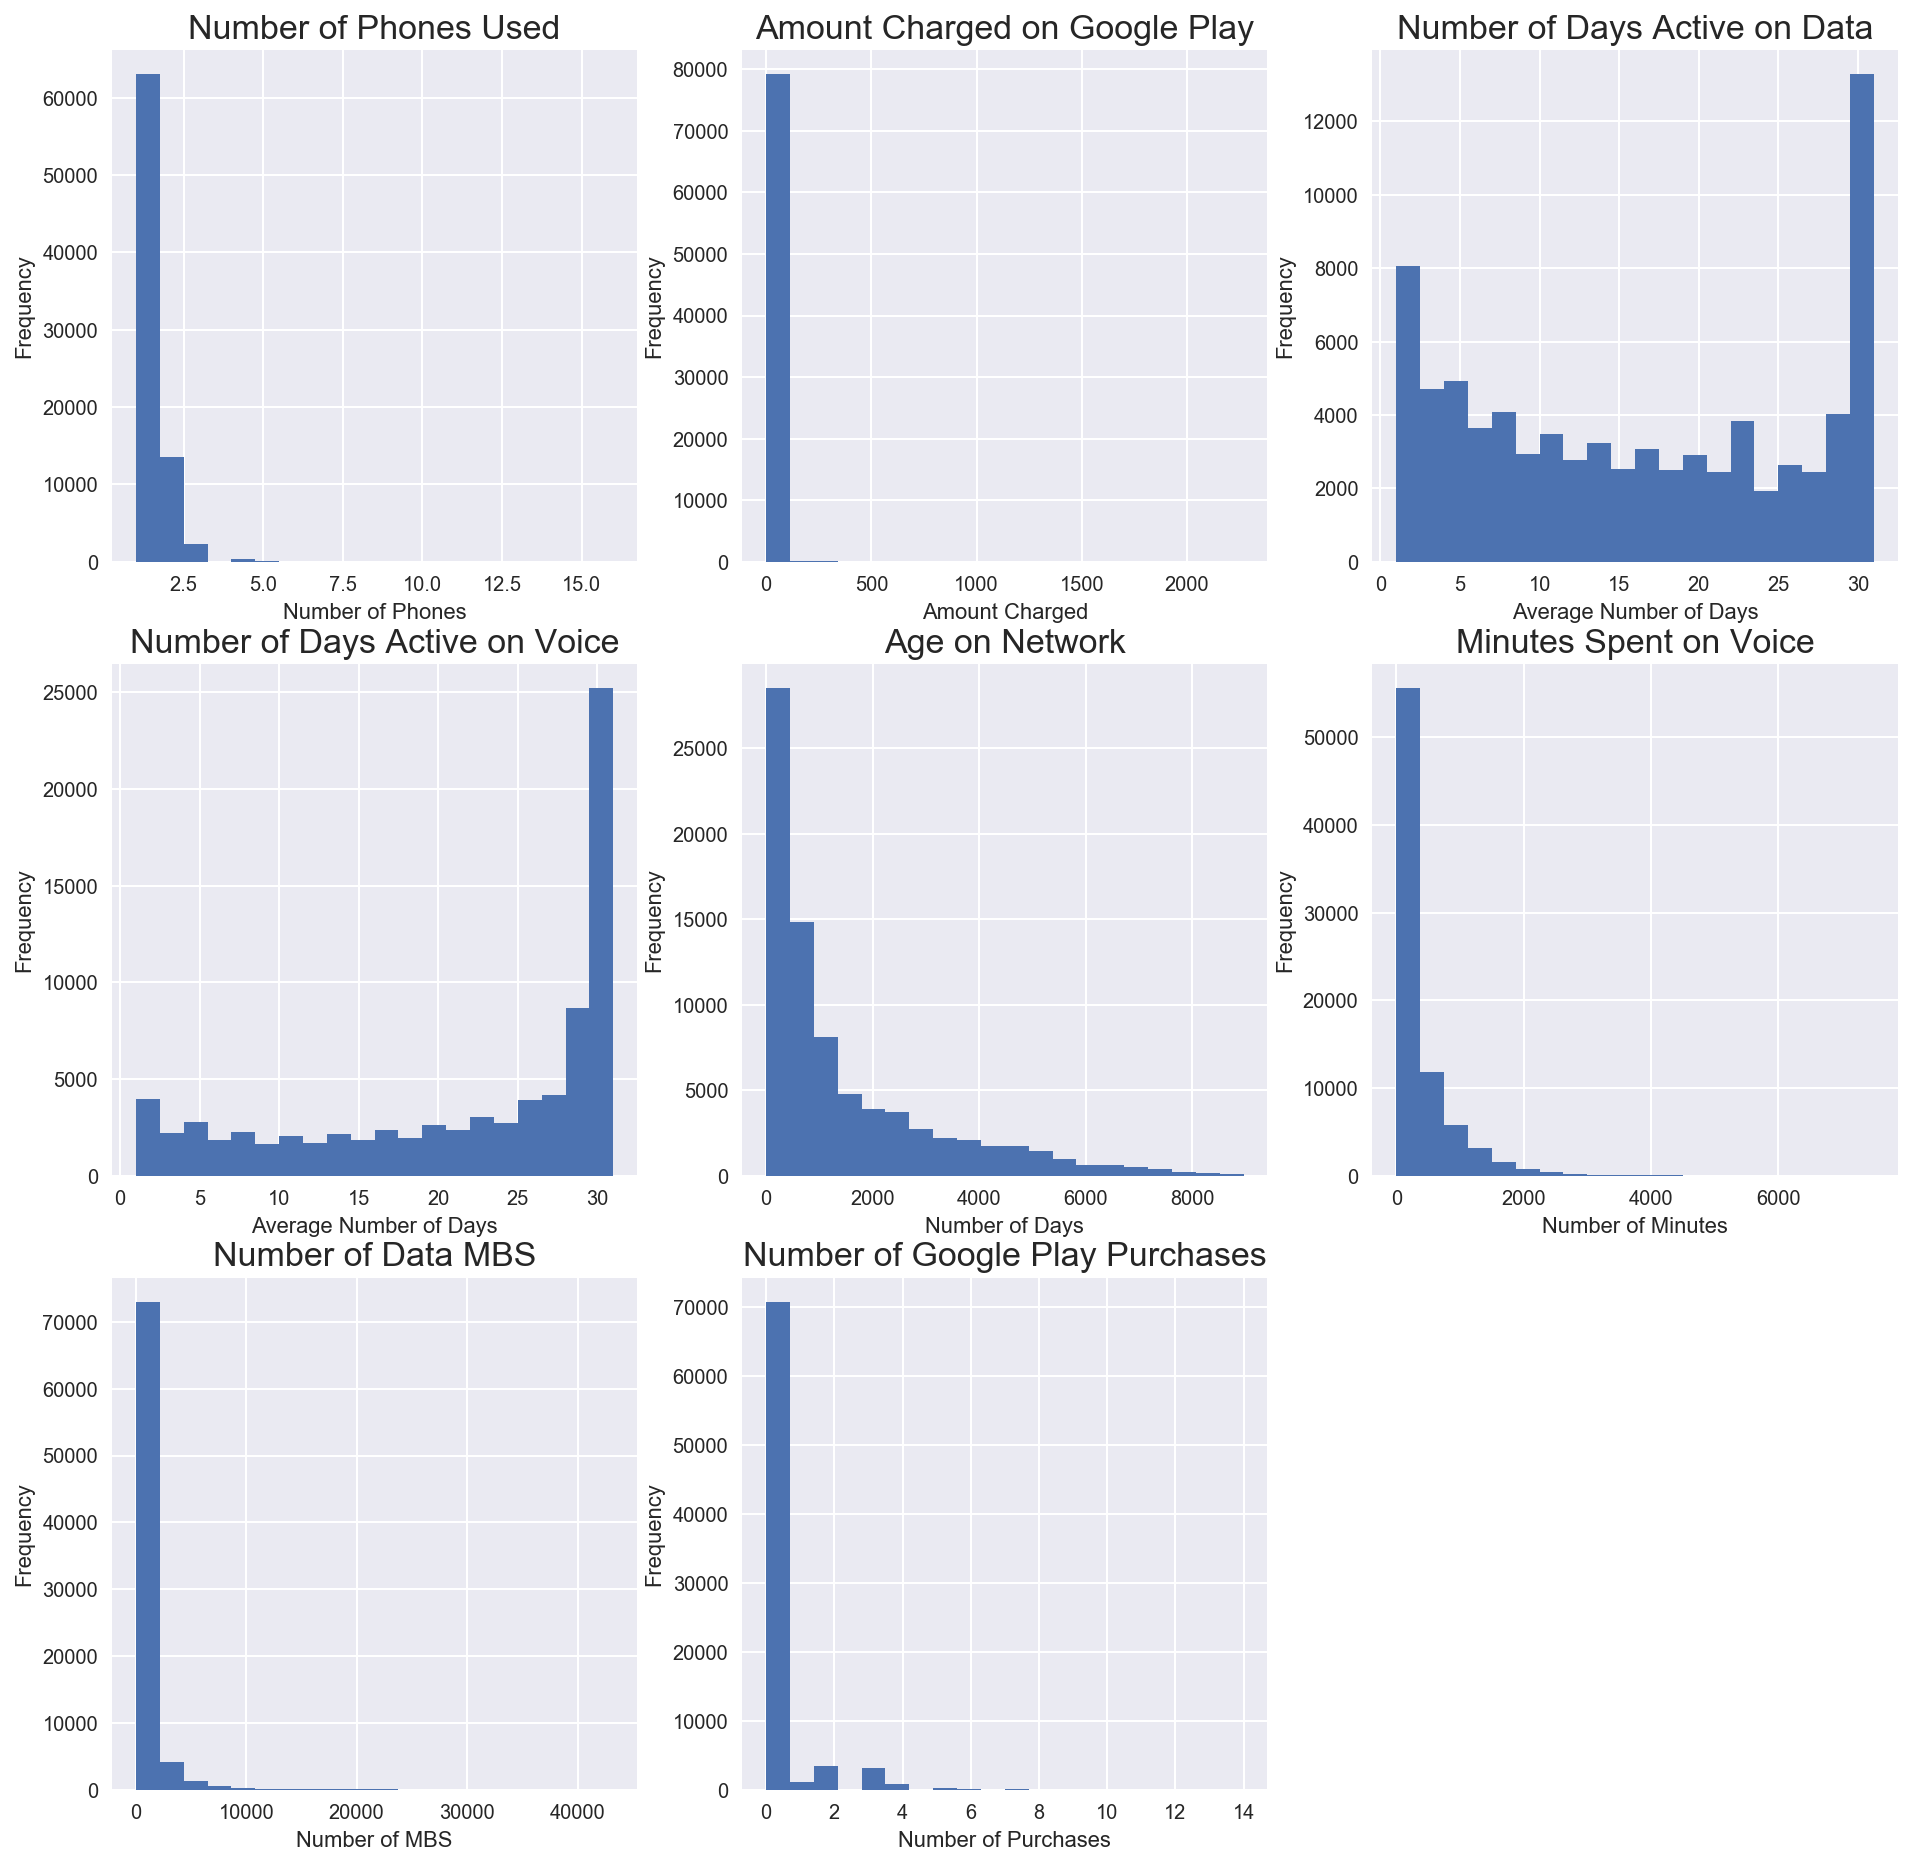

In [989]:
plt.figure(figsize=(16,16))

plt.subplot(3,3,1)
plt.title("Number of Phones Used",fontsize = 17)
plt.hist(df8["MANUFACTURER"],bins=20)
plt.ylabel("Frequency")
plt.xlabel("Number of Phones")

plt.subplot(3,3,2)
plt.title("Amount Charged on Google Play",fontsize = 17)
plt.hist(df8["AMOUNT_EXCL_VAT"],bins=20)
plt.ylabel("Frequency")
plt.xlabel("Amount Charged")



plt.subplot(3,3,3)
plt.title("Number of Days Active on Data",fontsize = 17)
plt.hist(df8["CNT_ACTV_DATA_DAYS"],bins=20)
plt.ylabel("Frequency")
plt.xlabel("Average Number of Days")


plt.subplot(3,3,4)
plt.title("Number of Days Active on Voice",fontsize = 17)
plt.hist(df8["CNT_ACTV_VOICE_DAYS"],bins=20)
plt.ylabel("Frequency")
plt.xlabel("Average Number of Days")


plt.subplot(3,3,5)
plt.title("Age on Network",fontsize = 17)
plt.hist(df8["CONNECTED_DAYS"],bins=20)
plt.ylabel("Frequency")
plt.xlabel("Number of Days")


plt.subplot(3,3,6)
plt.title("Minutes Spent on Voice",fontsize = 17)
plt.hist(df8["EVENT_DUR_MIN"],bins=20)
plt.ylabel("Frequency")
plt.xlabel("Number of Minutes")


plt.subplot(3,3,7)
plt.title("Number of Data MBS",fontsize = 17)
plt.hist(df8["TOTAL_VOL_MB"],bins=20)
plt.ylabel("Frequency")
plt.xlabel("Number of MBS")


plt.subplot(3,3,8)
plt.title("Number of Google Play Purchases",fontsize = 17)
plt.hist(df8["TOT_NUM_PURCHASES"],bins=20)
plt.ylabel("Frequency")
plt.xlabel("Number of Purchases")


plt.show()

- We have few customers who used a many as 16 devices in 3 months

- Customers are more engaged on voice than data. Both the distributions seem to have even peaks. 

- Most of the customers have zero amount charged on google play, this because of the distribution of the inbalanced state of our data.(80% did not purchase). A similar distribution is seen on the number of purchases.


- The Number of Data MBs used are highly skewed. Most customers have an average of almost zero.



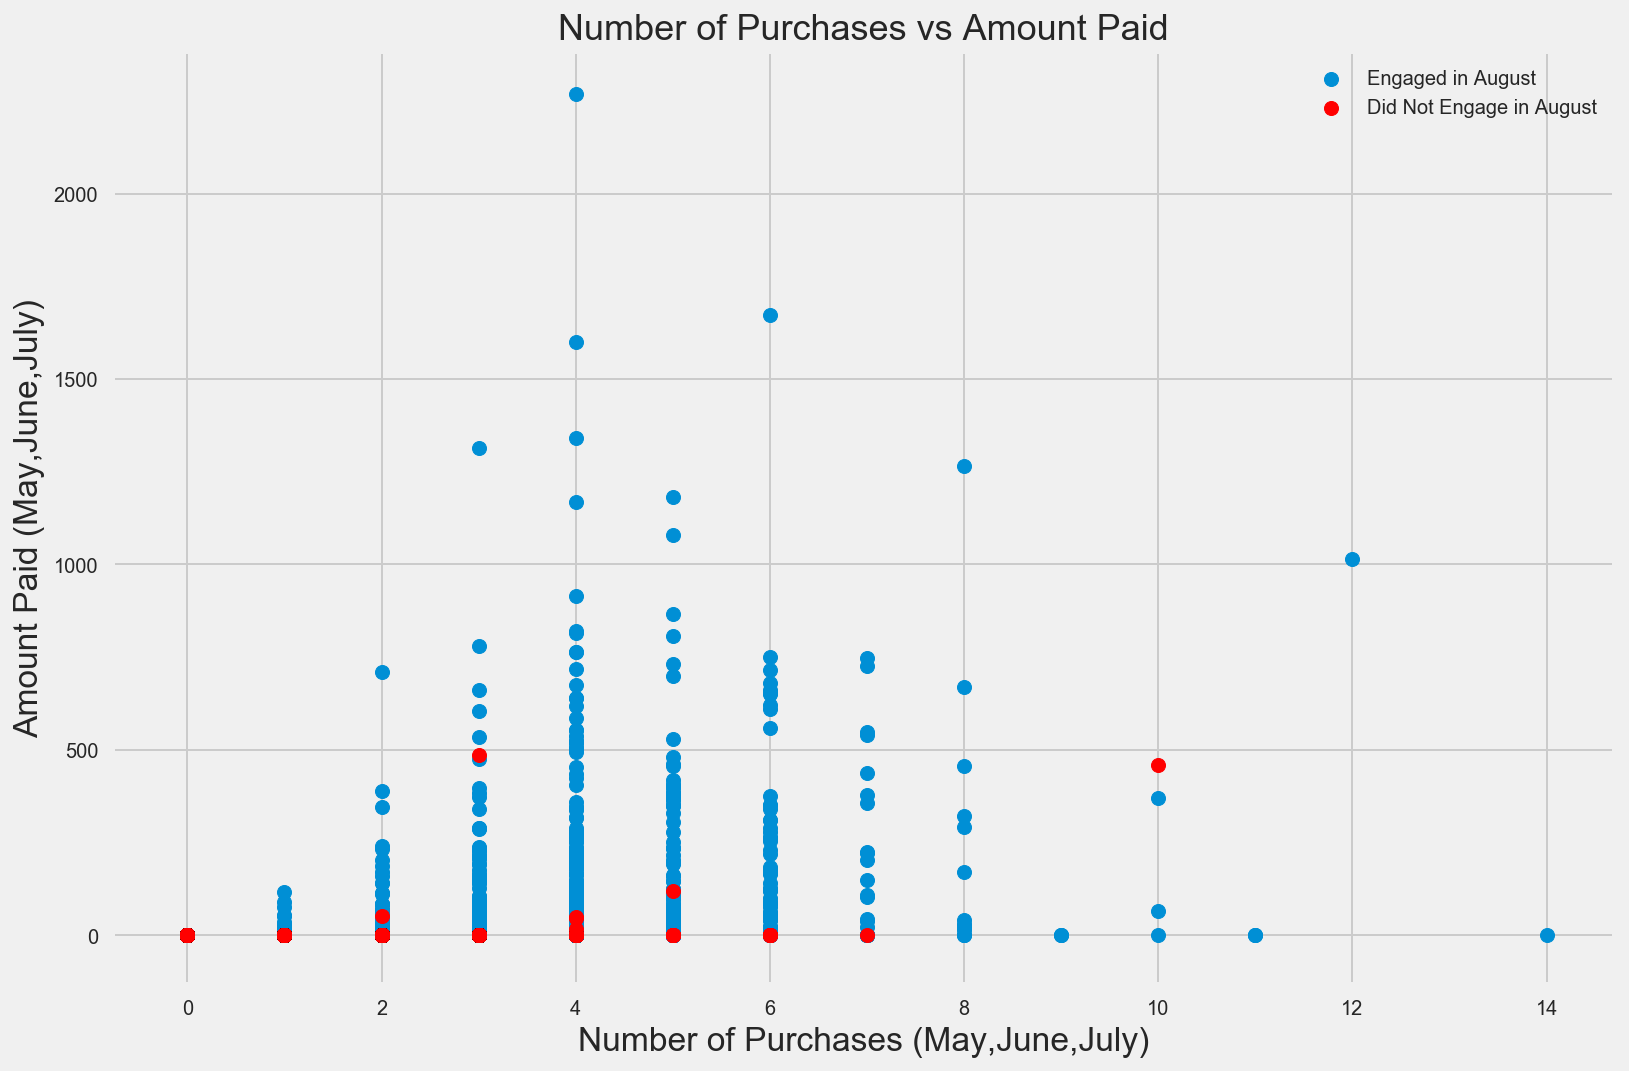

In [1490]:
plt.figure(figsize=(12,8))

plt.title("Number of Purchases vs Amount Paid",fontsize = (18))
plt.scatter(x="TOT_NUM_PURCHASES",y = "AMOUNT_EXCL_VAT" ,data =df8[df8.TARGET==1])

plt.scatter(x="TOT_NUM_PURCHASES",y = "AMOUNT_EXCL_VAT" ,data =df8[df8.TARGET==0],c= 'r')
plt.ylabel("Amount Paid (May,June,July)")
plt.xlabel("Number of Purchases (May,June,July)")
plt.legend(["Engaged in August","Did Not Engage in August"])
plt.show()

The people who with a high average also bought in August,this could indacate repeat customers

In [1011]:
#df8.groupby(by ="CNT_ACTV_VOICE_DAYS" )["CNT_ACTV_VOICE_DAYS"].count()

In [1046]:
m =pd.DataFrame(round(df8["CNT_ACTV_DATA_DAYS"]))
n = pd.DataFrame(round(df8["CNT_ACTV_VOICE_DAYS"]))

In [1048]:
m1= pd.DataFrame(m.groupby(by ="CNT_ACTV_DATA_DAYS")["CNT_ACTV_DATA_DAYS"].count())
n1 =pd.DataFrame(n.groupby(by ="CNT_ACTV_VOICE_DAYS")["CNT_ACTV_VOICE_DAYS"].count())
m1 =m1.rename(columns={"CNT_ACTV_DATA_DAYS":"Number_of_Customers"})
n1 =n1.rename(columns={"CNT_ACTV_VOICE_DAYS":"Number_of_Customers"})
m1.reset_index(inplace=True)
n1.reset_index(inplace=True)

/Users/dgitahi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=3,center=False).mean()
  """
/Users/dgitahi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=3,center=False).mean()
  del sys.path[0]


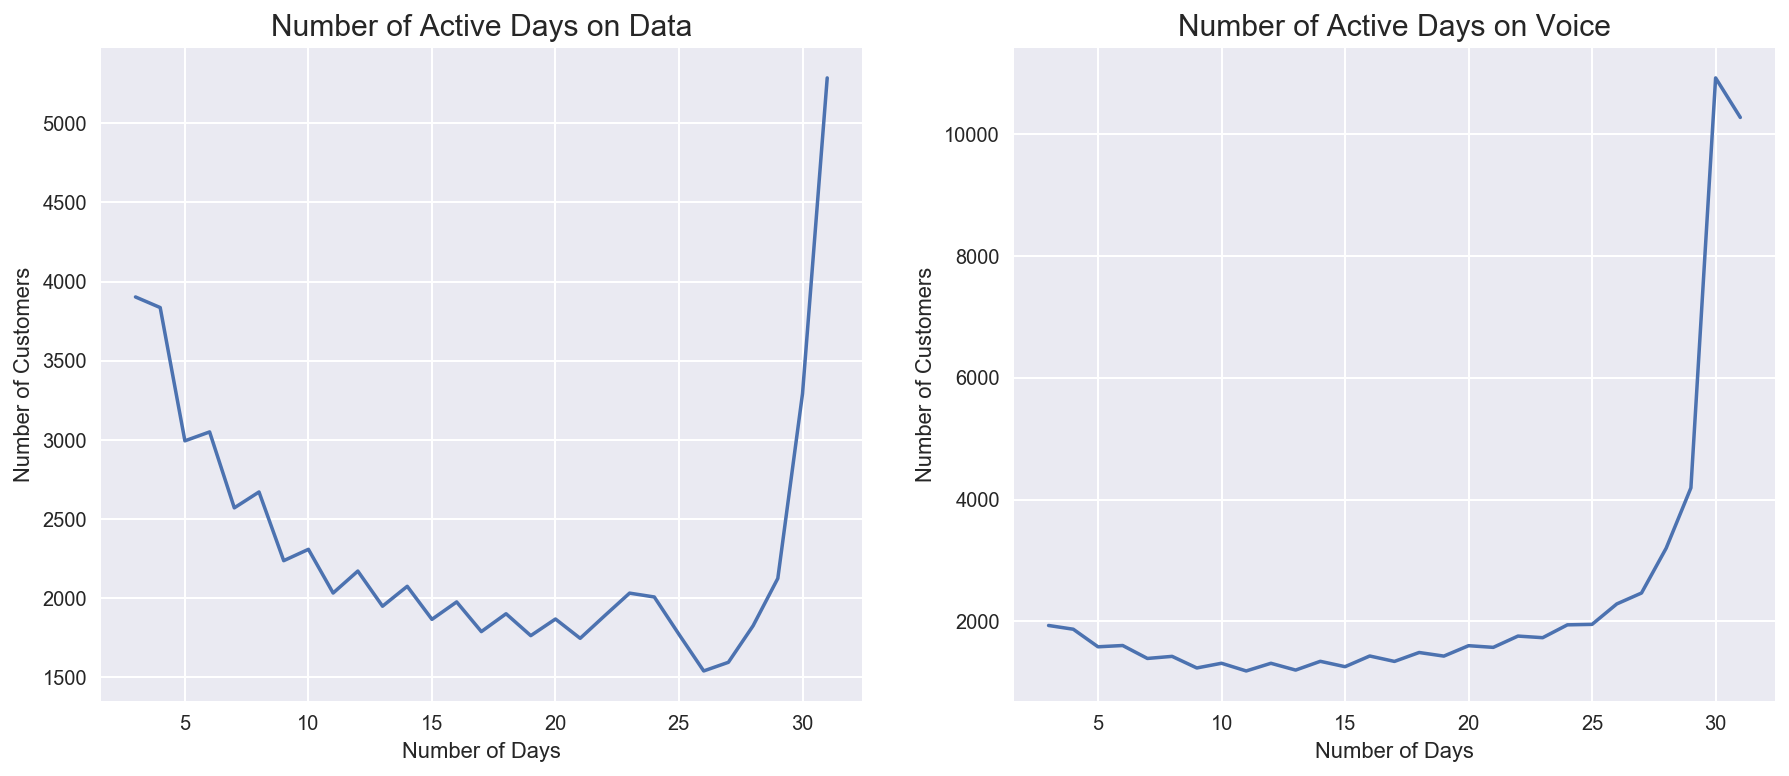

In [1056]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plt.title("Number of Active Days on Data",fontsize = (15))
plt.plot(m1.CNT_ACTV_DATA_DAYS,pd.rolling_mean(m1.Number_of_Customers,3))
plt.xlabel("Number of Days")
plt.ylabel("Number of Customers")



plt.subplot(1,2,2)
plt.title("Number of Active Days on Voice",fontsize = (15))
plt.plot(n1.CNT_ACTV_VOICE_DAYS,pd.rolling_mean(n1.Number_of_Customers,3))
plt.xlabel("Number of Days")
plt.ylabel("Number of Customers")


plt.show()

The Data has many customers who are rarely use data. 

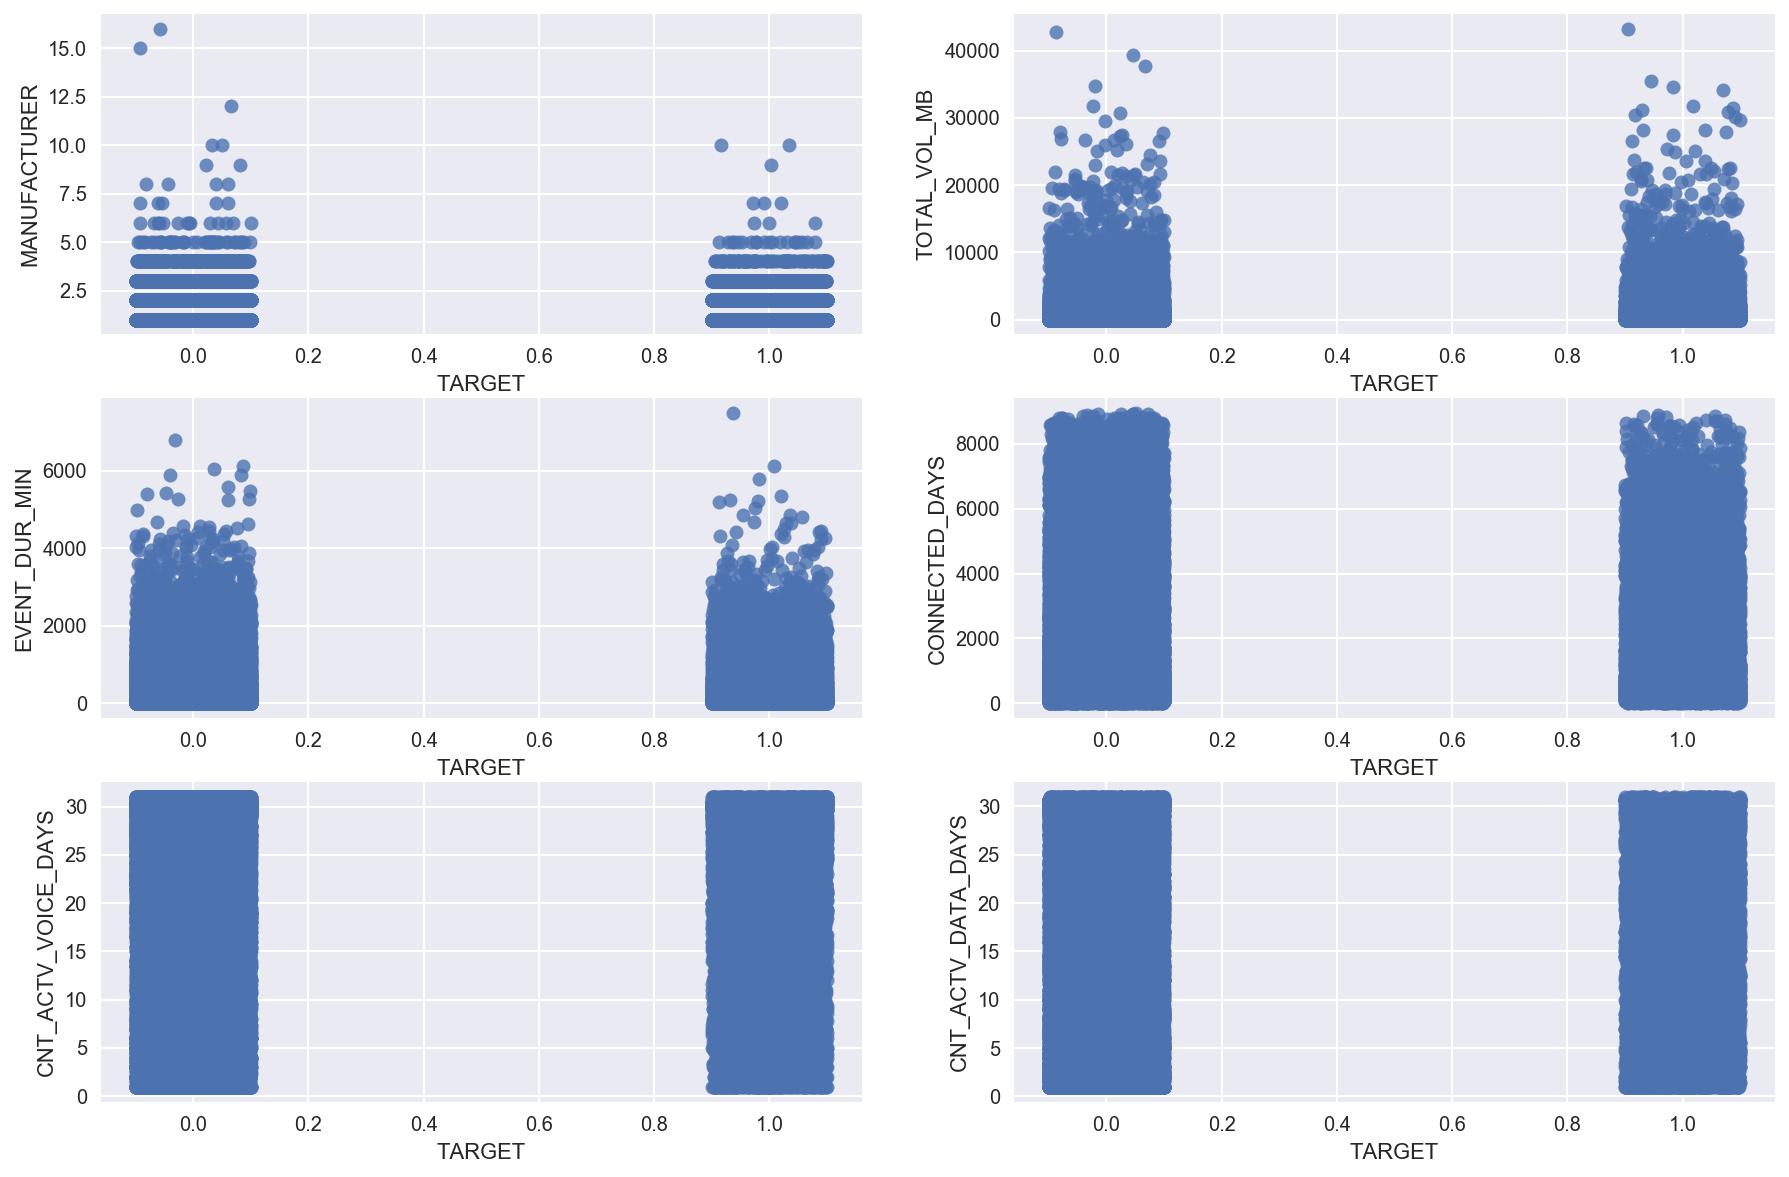

In [1069]:
plt.figure(figsize=(15,10))

plt.subplot(3,2,1)
sns.regplot(x= "TARGET",y = "MANUFACTURER",data = df8,fit_reg=False,x_jitter=0.1)

plt.subplot(3,2,2)
sns.regplot(x= "TARGET",y = "TOTAL_VOL_MB",data = df8,fit_reg=False,x_jitter=0.1)



plt.subplot(3,2,3)
sns.regplot(x= "TARGET",y = "EVENT_DUR_MIN",data = df8,fit_reg=False,x_jitter=0.1)



plt.subplot(3,2,4)
sns.regplot(x= "TARGET",y = "CONNECTED_DAYS",data = df8,fit_reg=False,x_jitter=0.1)

plt.subplot(3,2,5)
sns.regplot(x= "TARGET",y = "CNT_ACTV_VOICE_DAYS",data = df8,fit_reg=False,x_jitter=0.1)


plt.subplot(3,2,6)
sns.regplot(x= "TARGET",y = "CNT_ACTV_DATA_DAYS",data = df8,fit_reg=False,x_jitter=0.1)


plt.show()

Most of the features dont have a distinct difference between those who bought and did not buy the digital content.

It is expected then that the features may not have a very strong predictive power.

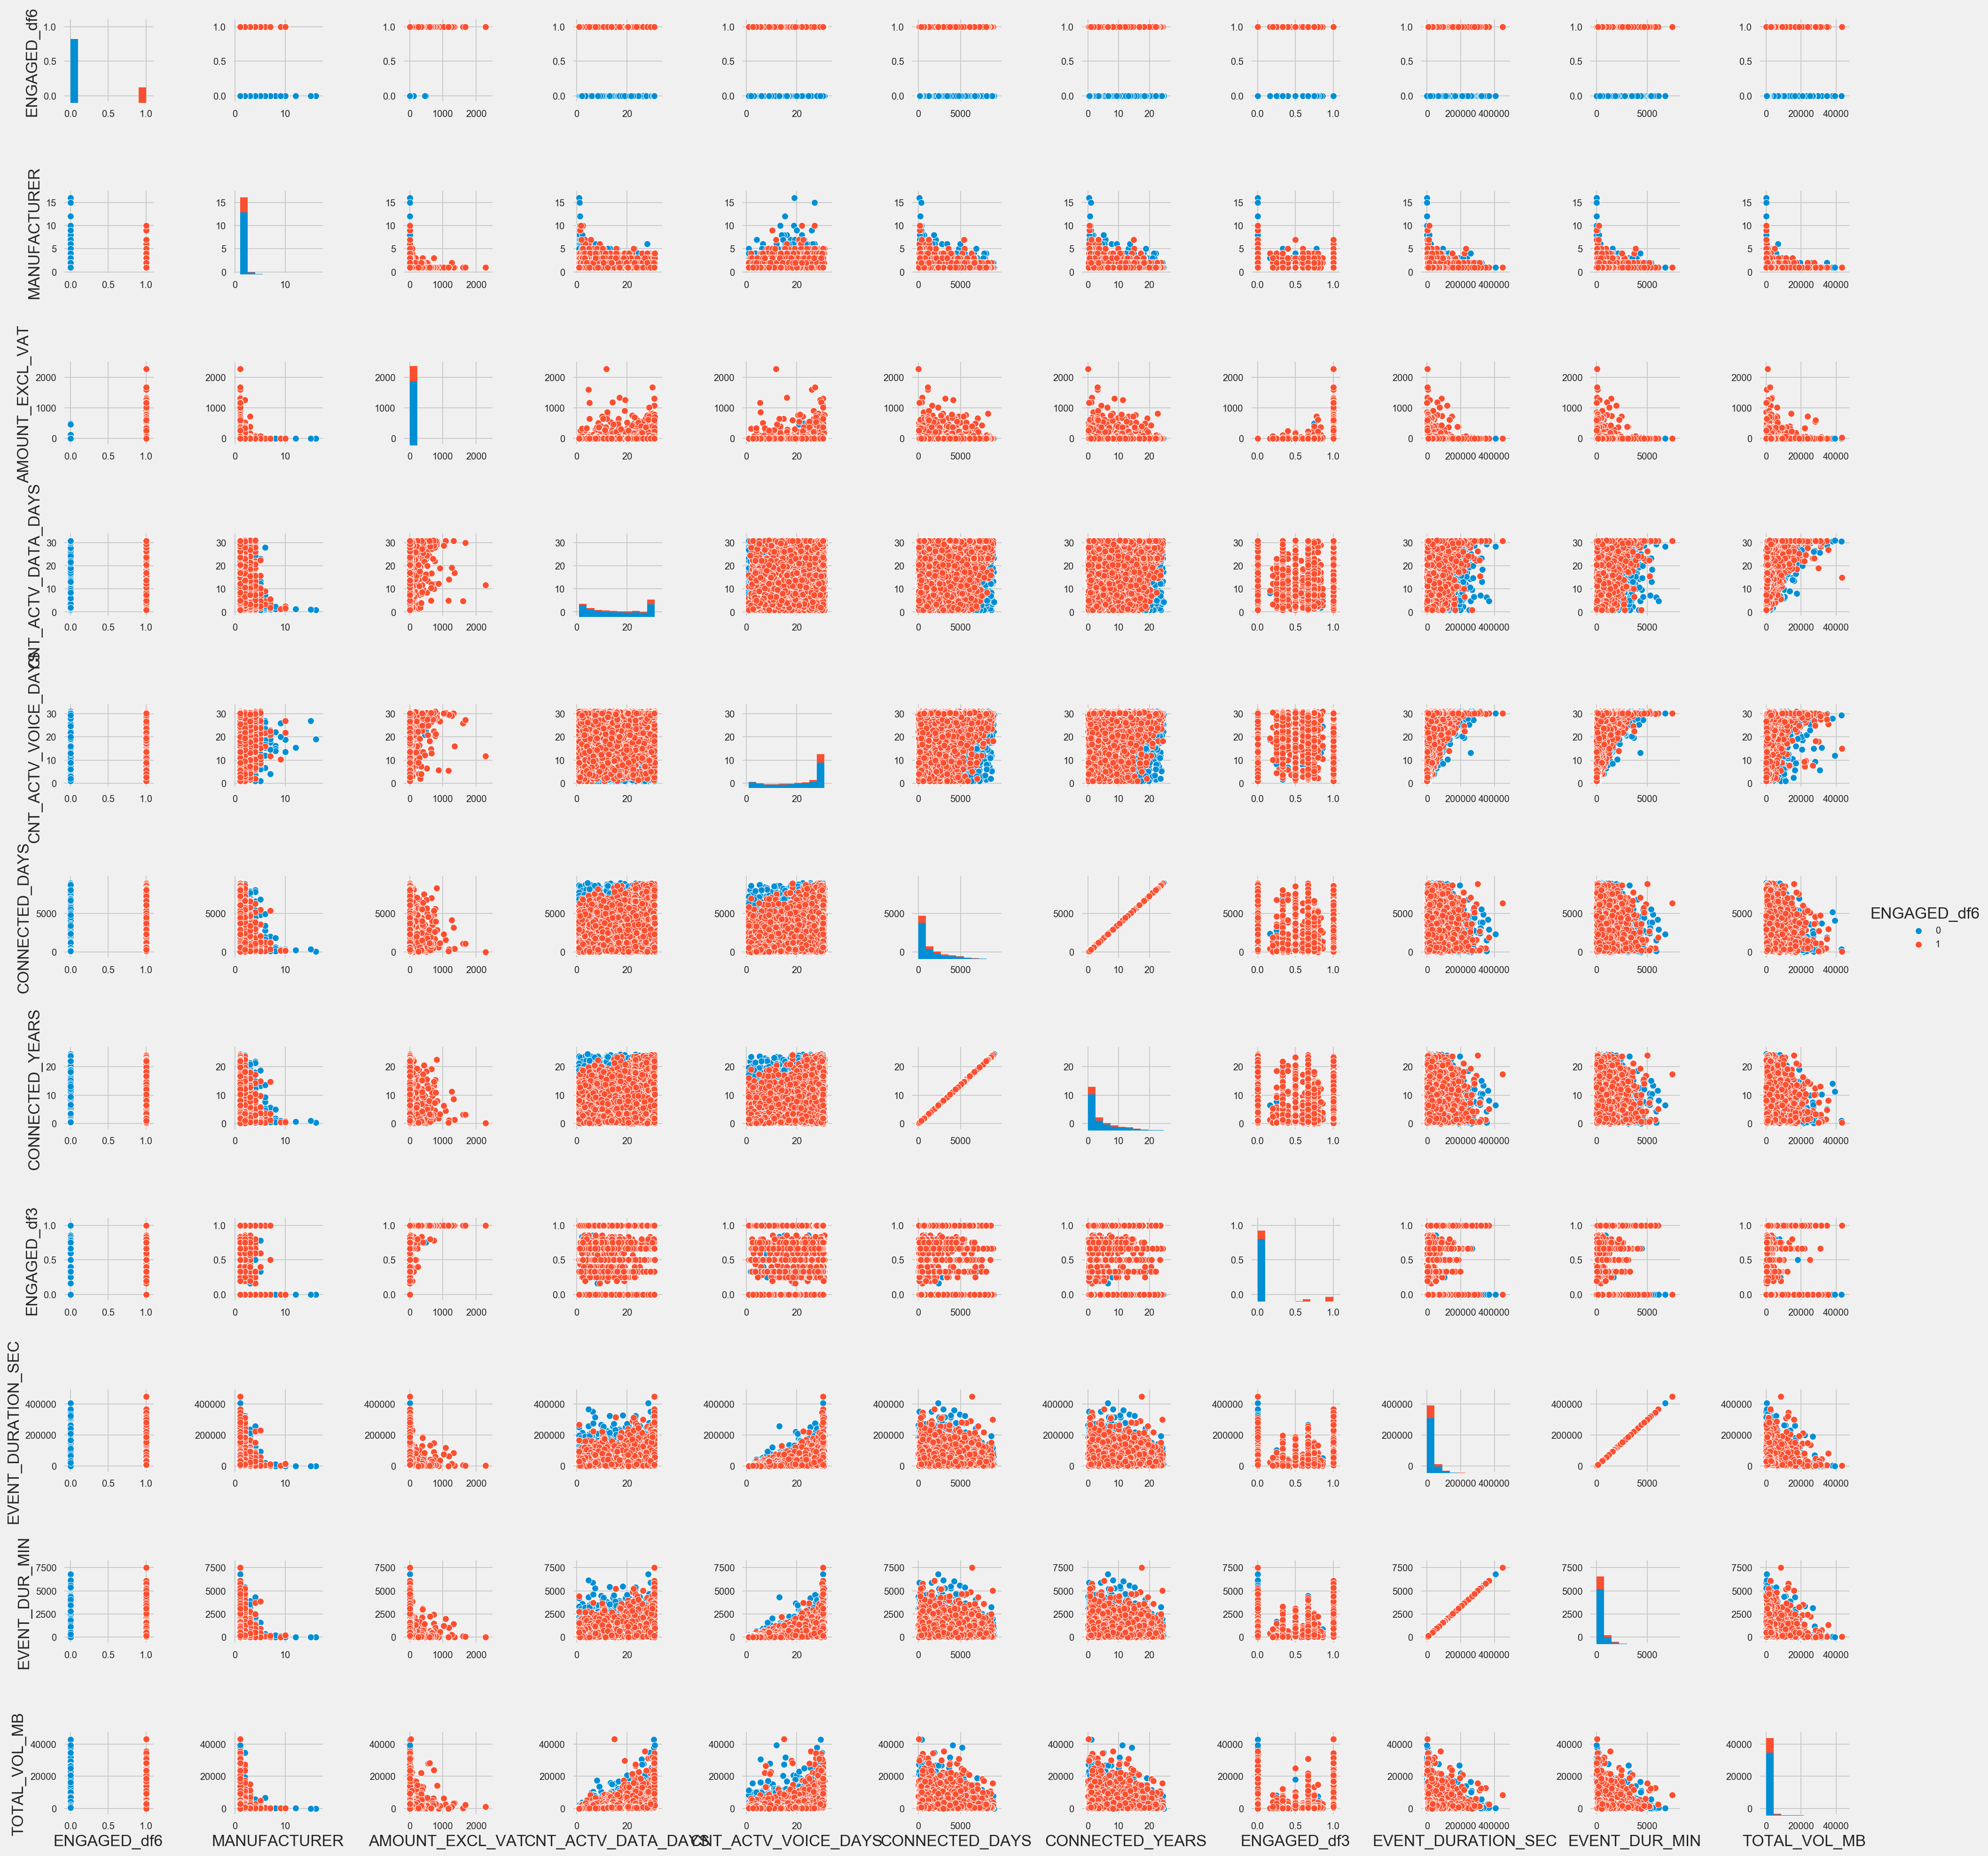

In [1491]:
sns.pairplot(data=df7,hue='ENGAGED_df6')
plt.show()

### Testing the Correlations 

In [1481]:
df8.corr()

,TARGET,MANUFACTURER,AMOUNT_EXCL_VAT,CNT_ACTV_DATA_DAYS,CNT_ACTV_VOICE_DAYS,CONNECTED_DAYS,EVENT_DUR_MIN,TOTAL_VOL_MB,TOT_NUM_PURCHASES,Data_Voice
TARGET,1.000000,0.018603,0.098413,0.171440,0.159952,0.072631,0.093490,0.180040,0.540292,0.015417
MANUFACTURER,0.018603,1.000000,-0.009493,-0.208959,-0.055707,-0.097159,-0.024736,-0.069381,0.048374,-0.176256
AMOUNT_EXCL_VAT,0.098413,-0.009493,1.000000,0.034426,0.021545,0.018140,0.004974,0.075528,0.241173,0.010350
CNT_ACTV_DATA_DAYS,0.171440,-0.208959,0.034426,1.000000,0.582515,0.250054,0.228164,0.380483,0.125892,0.455331
CNT_ACTV_VOICE_DAYS,0.159952,-0.055707,0.021545,0.582515,1.000000,0.334854,0.458177,0.203426,0.110896,-0.204869
CONNECTED_DAYS,0.072631,-0.097159,0.018140,0.250054,0.334854,1.000000,0.208613,0.116655,0.050059,-0.020106
EVENT_DUR_MIN,0.093490,-0.024736,0.004974,0.228164,0.458177,0.208613,1.000000,0.140715,0.027798,-0.114802
TOTAL_VOL_MB,0.180040,-0.069381,0.075528,0.380483,0.203426,0.116655,0.140715,1.000000,0.168458,0.164635
TOT_NUM_PURCHASES,0.540292,0.048374,0.241173,0.125892,0.110896,0.050059,0.027798,0.168458,1.000000,0.021752
Data_Voice,0.015417,-0.176256,0.010350,0.455331,-0.204869,-0.020106,-0.114802,0.164635,0.021752,1.000000


We don't have any features that are highly correlated. We can therefore include all the features in the model

### Feature Engeneering

The Ratio of Data duration to Voice duration is a good indicator of the customers who are skewed to using Data

In [1193]:
df8["Data_Voice"]=np.divide(df8.CNT_ACTV_DATA_DAYS,np.add(df8.CNT_ACTV_VOICE_DAYS,1))

## MODEL

Our Baseline Model is a Logistic Regression Model

In [1235]:
y = df8['TARGET']
X = df8.drop(['TARGET','MSISDN','MANUFACTURER', 'AMOUNT_EXCL_VAT'], axis=1)
#X.drop("MSISDN",axis=1,inplace = True)
#X.drop("AMOUNT_EXCL_VAT",axis=1,inplace = True)
# y = data_cp['Churn'].values
# X = data_transformed.values

In [1236]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
  train_test_split(X, y, test_size=0.25, random_state=123)

In [1237]:
from sklearn.linear_model import LogisticRegression

### The First Iteration of Logistic Regression

In [1238]:
logmodel = LogisticRegression()

In [1239]:
logmodel.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [1240]:
predictions = logmodel.predict(X_test)

#### Confusion Matrix First Iteration

In [1241]:
from sklearn.metrics import classification_report, confusion_matrix

In [1242]:
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

          0       0.87      0.98      0.92     15876
          1       0.85      0.43      0.57      3971

avg / total       0.87      0.87      0.85     19847



** The Model has a  Recall of 43% and Precision of 85%**


With default cutoff of point of 0.5 the model is performing poorly. We try to adjust and find an optimal cutoff where the model is more sensitive to detect more of the potential buyers

In [1243]:
predictions_probability = logmodel.predict_proba(X_test)

In [1244]:
y =pd.DataFrame(y_test)

In [1245]:
predictions_probability[:,:0]

array([], shape=(19847, 0), dtype=float64)

In [1246]:
y["prob"]= predictions_probability[:,1]

In [1247]:
y_test.shape

(19847,)

### The Second Iteration of Logistic Regression

Since our model sensitivity is very low, we tune it by increasing the sensitivity. This means we lower the cut off point

In [1248]:
y['prob_d'] = np.where(y['prob']<=0.20, 0, 1)

#### Confusion Matrix for the Second Iteration

In [1249]:
pd.crosstab(y.prob_d, y.TARGET, margins=True)

TARGET,0,1,All
prob_d,,,
0,14859,1864,16723
1,1017,2107,3124
All,15876,3971,19847


In [1250]:
print(classification_report(y['TARGET'], y['prob_d']))

             precision    recall  f1-score   support

          0       0.89      0.94      0.91     15876
          1       0.67      0.53      0.59      3971

avg / total       0.85      0.85      0.85     19847



The Model Performance has improved to ** Recall of 53% ** and ** Precision of 67%** 

In [1211]:
from sklearn.metrics import roc_curve, auc

In [1212]:
fpr, tpr, thresholds = roc_curve(y_test, predictions_probability[:,1])

In [1213]:
roc_auc = auc( fpr,tpr)
print("Area under the ROC curve : %f" % roc_auc)

Area under the ROC curve : 0.794930


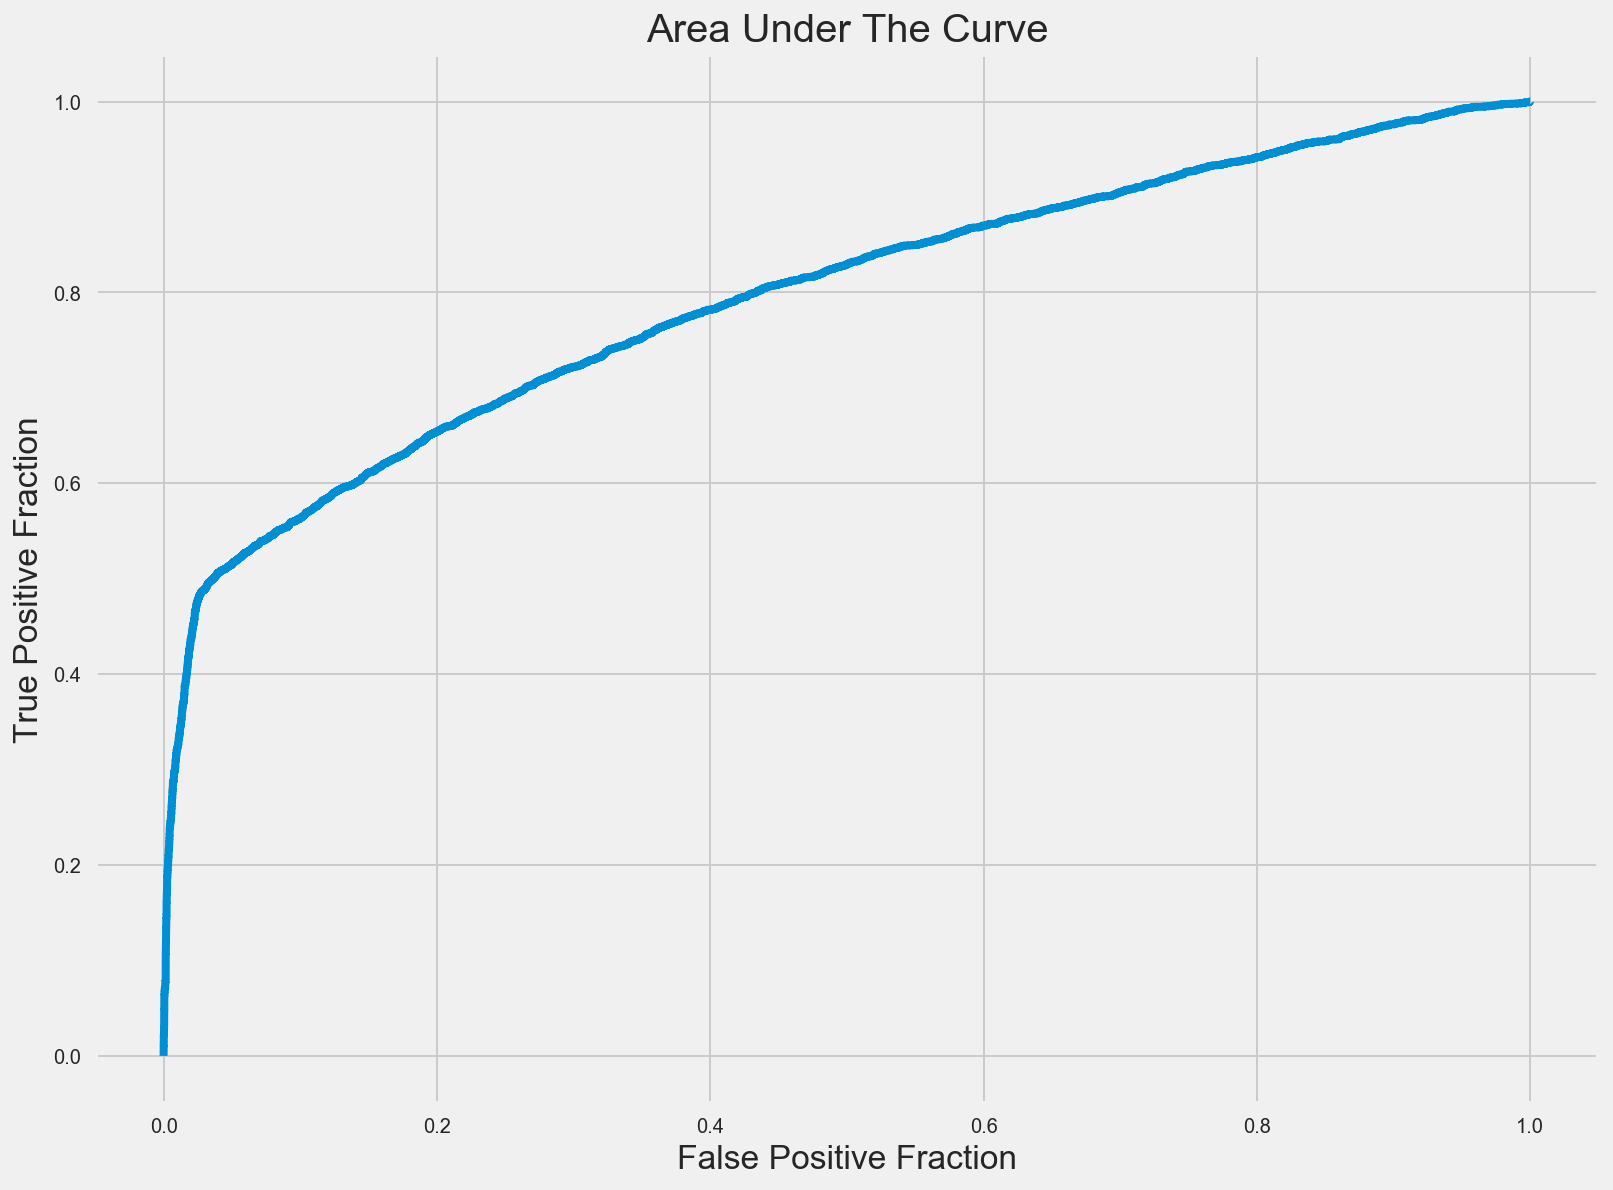

In [1214]:
plt.figure(figsize=(12,9))
plt.title("Area Under The Curve",fontsize = (20))
plt.plot(fpr,tpr)
plt.ylabel("True Positive Fraction")
plt.xlabel("False Positive Fraction")
plt.show()

The Area under the Curve is ** 80%**

## Random Forest

In [1251]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix


#### Grind Search for the Optimal Hyperparameter

We run a Grind search for the optimal hyperparameters to used in the model

In [1426]:
from time import time
from scipy.stats import randint as sp_randint
from scipy.stats import uniform
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
#from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier

# get some data
#digits = load_digits()
#X_train, Y_train = digits.data, digits.target

# build a classifier
clf = RandomForestClassifier(n_estimators=100)


# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


# specify parameters and distributions to sample from
param_dist = {"max_depth": [3, None],
              #"max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search)

start = time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

# use a full grid over all parameters
param_grid = {"max_depth": [3, None],
              #"max_features": [0, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run grid search
grid_search = GridSearchCV(clf, param_grid=param_grid)
start = time()
grid_search.fit(X_train, y_train)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))
report(grid_search.cv_results_)

RandomizedSearchCV took 258.59 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.876 (std: 0.002)
Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 9, 'min_samples_split': 9}

Model with rank: 1
Mean validation score: 0.876 (std: 0.002)
Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 7}

Model with rank: 1
Mean validation score: 0.876 (std: 0.002)
Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 3}



KeyboardInterrupt: 

In [1453]:
rf_model = RandomForestClassifier(n_estimators=200,criterion='entropy',max_depth = 3,
                                  min_samples_leaf = 9,min_samples_split= 9)

#### Model with the Optimal Hypeperameters

In [1454]:
rf_model.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=9, min_samples_split=9,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [1455]:
predictionsnw = rf_model.predict(X_test)

In [1456]:
## Take a look at the confusion matrix ([TN,FN],[FP,TP])
confusion_matrix(y_test,predictions)

array([[15483,   393],
       [ 2067,  1904]])

#### Confusion Matrix first Iterations

In [1457]:
## Print classification report
print(classification_report(y_test, predictionsnw))

             precision    recall  f1-score   support

          0       0.88      0.98      0.93     15876
          1       0.84      0.48      0.61      3971

avg / total       0.87      0.88      0.86     19847



The model doesnt perform well with the cutoff of 50%. We can run another iteration by just adjusting the cutoff

** The Model has a  Recall of 48% and Precision of 84%**

In [1458]:
predictions_probability = rf_model.predict_proba(X_test)

In [1459]:
y1 =pd.DataFrame(y_test)

In [1460]:
y1["prob"]= predictions_probability[:,1]

In [1470]:
y1['prob_d'] = np.where(y1['prob']<=0.24, 0, 1)

#### Confusion Matrix Second Iterations

In [1471]:
pd.crosstab(y1.prob_d, y1.TARGET, margins=True)

TARGET,0,1,All
prob_d,,,
0,14734,1804,16538
1,1142,2167,3309
All,15876,3971,19847


In [1472]:
print(classification_report(y1['TARGET'], y1['prob_d']))

             precision    recall  f1-score   support

          0       0.89      0.93      0.91     15876
          1       0.65      0.55      0.60      3971

avg / total       0.84      0.85      0.85     19847



 We Adjust the Cutoff to make the model more sensitive, to a cut off of 0.35

The Model Performance has improved to ** Recall of 55% ** and ** Precision of 65%** 



### Variable Importance

In [1261]:
features = X
feature_list = X.columns

# Get numerical feature importances
importances = list(rf_model.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 4)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
for pair in feature_importances:
  print('Variable: {:20} Importance: {}'.format(*pair))

Variable: TOT_NUM_PURCHASES    Importance: 0.2368
Variable: TOTAL_VOL_MB         Importance: 0.1834
Variable: EVENT_DUR_MIN        Importance: 0.1553
Variable: CONNECTED_DAYS       Importance: 0.1484
Variable: Data_Voice           Importance: 0.1064
Variable: CNT_ACTV_DATA_DAYS   Importance: 0.0879
Variable: CNT_ACTV_VOICE_DAYS  Importance: 0.0818


In [1262]:
rf_model.feature_importances_

array([ 0.08787928,  0.08181767,  0.14842251,  0.15532129,  0.18335497,
        0.2367989 ,  0.10640537])

Text(0.5,1,'Variable Importances')

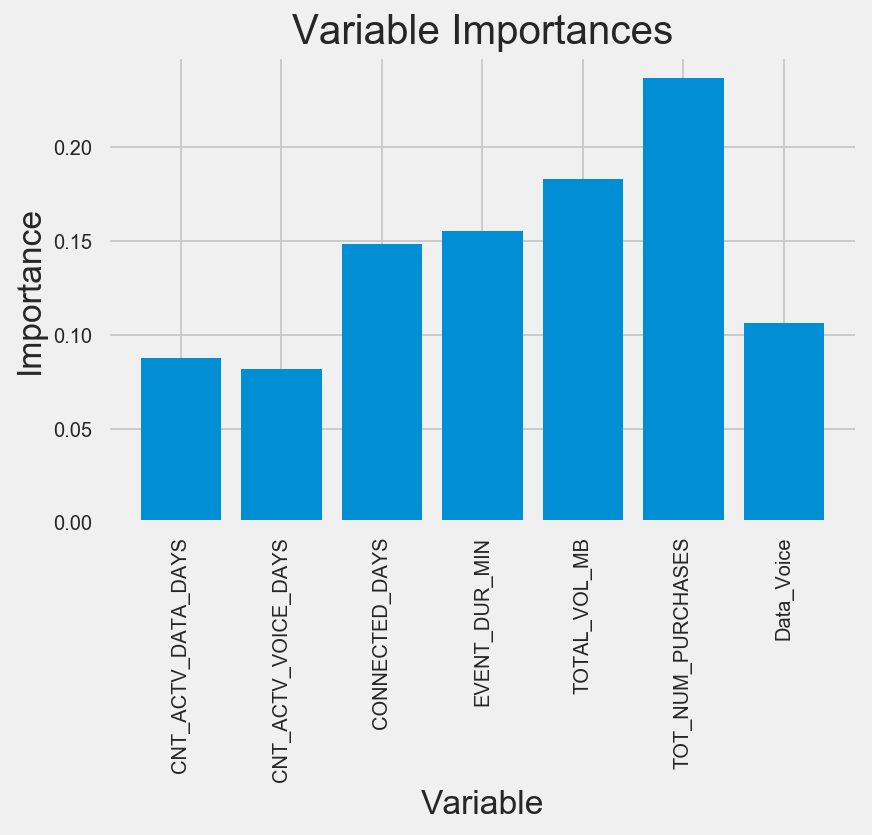

In [1263]:
# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt

%matplotlib inline

# Set the style
plt.style.use('fivethirtyeight')

# list of x locations for plotting
x_values = list(range(len(importances)))

# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')

# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')

# Axis labels and title
plt.ylabel('Importance')
plt.xlabel('Variable')
plt.title('Variable Importances')

- The previous purchases a good indicator of customers who will buy.






- Data usage is also a good indicator of potential customer

In [1483]:
k = pd.DataFrame(y_test)
k["kk"] =predictions_probability[0:,:1]

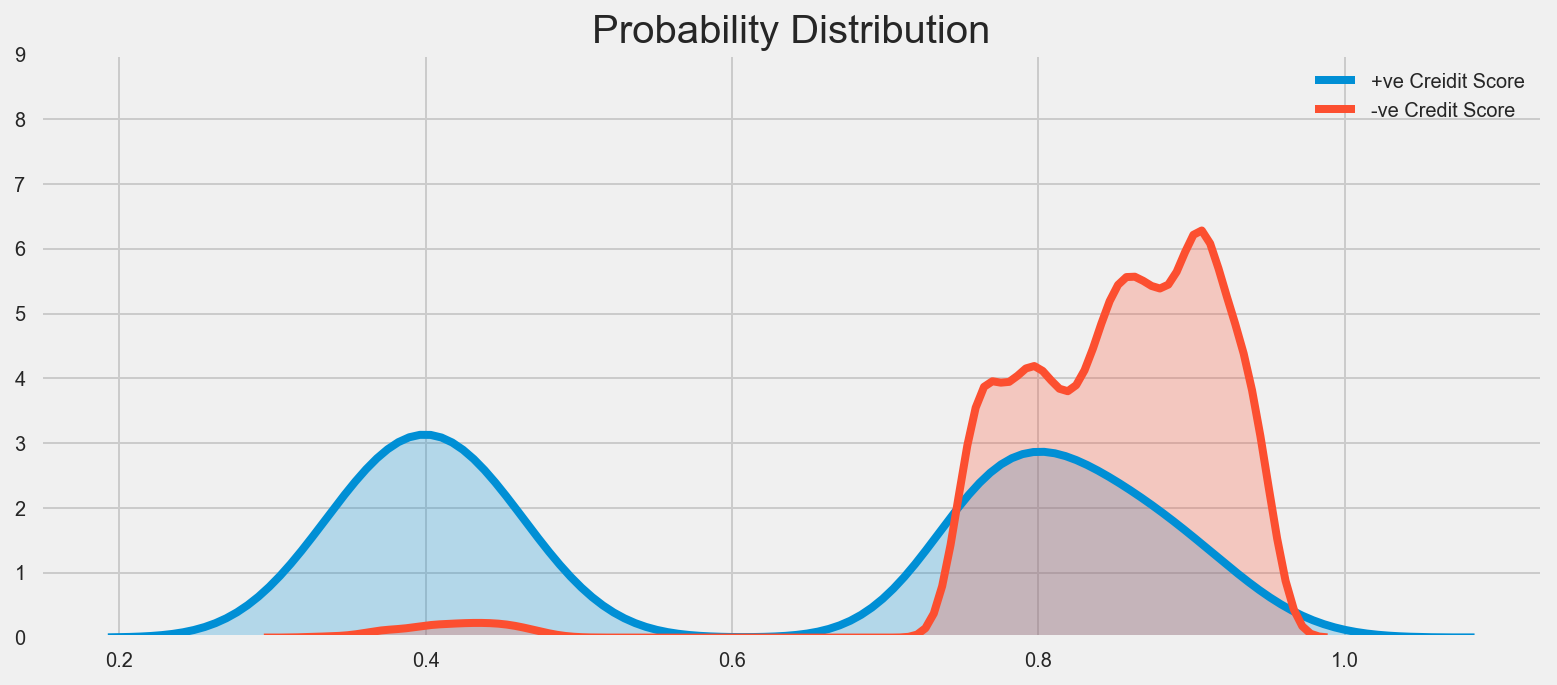

In [1487]:
plt.figure(figsize=(12,5))
plt.title("Probability Distribution",fontsize= 20)
sns.kdeplot(k[k.TARGET == 1]["kk"],shade =True)
sns.kdeplot(k[k.TARGET == 0]["kk"],shade =True)
plt.ylim(0,9)
plt.legend(["+ve Creidit Score","-ve Credit Score"])
plt.show()

### Conclusion
The purpose of this study was to determine if we are able to use machine learning and 3 months worth of historical data to train a model that will be able to predict and identify new customers to which Vodacom can expand and market the digital contents offering.

Using limited data and resources we were able to gain insights and determine that there is potential to inform Vodacom better on campaigns and how to expand the current digital services offering.

This MVP(Minimum Viable Product) is productionable and can be implemented on a fraction of the base. However, better results and model performance can be gained by sourcing more data that will provide a holistic view on the customer.